In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import torch
import torch.nn as nn

In [2]:
# hyperparams
x_range = [0,2]
n_data = 1000
input_dim = 1
taus = [0.1, 0.2, 0.5, 0.7, 0.9, 1.0]
n_quantiles = len(taus)
device = 'cpu'
n_epochs = 200
batch_size = 128
n_hidden = 100
y_max = 20.

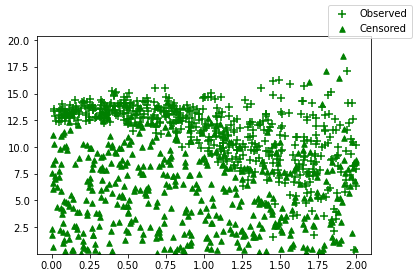

In [3]:
# generate dataset
class DatasetMini:
	def get_observe_times(self, x):
		return np.clip(np.random.normal(loc=self.param1_target(x), scale = self.param2_target(x)),0.1,10000)
	def get_censor_times(self, x):
		return np.random.uniform(self.param1_cen(x), self.param1_cen(x)+self.param2_cen(x))
	def get_quantile_truth(self, x, q):
		return scipy.stats.norm(self.param1_target(x),self.param2_target(x)).ppf(q)
	def get_mean_truth(self, x):
		return scipy.stats.norm(self.param1_target(x),self.param2_target(x)).mean()
	def get_censored_quantile_truth(self, x, q):
		return scipy.stats.uniform(loc=self.param1_cen(x),scale=self.param2_cen(x)).ppf(q)
	def param1_target(self,x):
		return 2*x*np.cos(2*x)+13
	def param2_target(self,x):
		return (x**2+1/2)
	def param1_cen(self,x):
		return x*0
	def param2_cen(self,x):
		return x*0+25
    
mydataset = DatasetMini()

x_train = np.random.uniform(x_range[0],x_range[1],size=(n_data,input_dim))
tte_train = mydataset.get_observe_times(x_train).flatten()
cen_train = mydataset.get_censor_times(x_train).flatten()
y_train = np.minimum(cen_train,tte_train)
cen_indicator = np.array([cen_train<tte_train])*1 # 1 if censored else 0
obs_indicator = np.array([cen_train>=tte_train])*1 # 1 if observed else 0

x_grid = np.linspace(x_train.min()-0.05,x_train.max()+0.05,100).reshape([1,-1]).T

# plot it
fig, ax = plt.subplots(1,1)
ax.scatter(x_train[:][cen_indicator[0,:] == 0], y_train[:][cen_indicator[0,:] == 0],color='g',marker='+',s=50,label='Observed')
ax.scatter(x_train[:][cen_indicator[0,:] == 1], y_train[:][cen_indicator[0,:] == 1],color='g',marker='^',s=30,label='Censored')
ax.set_ylim([y_train.min()*0.909,y_train.max()*1.1])
fig.legend()
fig.show()

In [4]:
# convert everything to torch tensors
y_train_torch = torch.tensor(y_train.reshape([1,-1]).T).float().to(device)
cen_indicator_torch = torch.tensor(cen_indicator.reshape([1,-1]).T).float().to(device)
taus_torch = torch.tensor(taus).reshape([1,-1]).float().to(device) # shape (1,n_quantiles)
x_train_torch = torch.tensor(x_train).float().to(device)
x_grid_torch = torch.tensor(x_grid).float().to(device)

In [5]:
# create model
class Model_mlp(nn.Module):
	# NN with two relu hidden layers
	# quantile outputs are independent of eachother
	def __init__(self,input_dim,n_hidden,n_quantiles):
		super(Model_mlp,self).__init__()
		self.layer1 = nn.Linear(input_dim,n_hidden,bias=True)
		self.layer2 = nn.Linear(n_hidden,n_hidden,bias=True)
		self.layer3 = nn.Linear(n_hidden,n_quantiles,bias=True)

	def forward(self,x):
		x = self.layer1(x)
		x = torch.nn.functional.gelu(x)
		x = self.layer2(x)
		x = torch.nn.functional.gelu(x)
		x = self.layer3(x)
		return x
  
model = Model_mlp(input_dim,n_hidden,n_quantiles)

In [6]:
def cqrnn_loss_slowforloops(y_pred, y_true, cen_indicator, taus, taus_torch, n_quantiles, y_max):
	# this is CQRNN loss as in paper
	# but this is the slow non parallelised version, with for loops 
	# (added for readability only, not recommended for use, esp. with large grid size!)

	# censored tilted multi loss
	loss_obs = 0
	
	y_pred_detach = y_pred.detach()
	estimated_quantiles = torch.zeros_like(cen_indicator)

	# tp combining first and second steps into same loop for efficiency
	for i in range(n_quantiles-1):
		tau = taus[i]
		loss_obs += torch.mean((cen_indicator<1)*(y_pred[:,i].reshape(-1,1)  - y_true)*((1-tau)-1.*(y_pred[:,i].reshape(-1,1)<y_true)))
		# (note this returns lower bound on quantile, not argmin)
		estimated_quantiles[y_true > y_pred_detach[:,i].reshape(-1,1)] = taus[i]

	# compute weights, eq 11, portnoy 2003
	weights = torch.zeros(cen_indicator.size(0), n_quantiles-1) # shape batch_size, n_quantiles 
	for i in range(n_quantiles-1):
		tau = taus[i]
		weights[:,i]  = (tau < estimated_quantiles.reshape(-1))*1.+ (tau >= estimated_quantiles.reshape(-1)) * (tau - estimated_quantiles.reshape(-1)) / (1 - estimated_quantiles.reshape(-1))

	# now compute censored loss using 
	# weight* censored value, + (1-weight)* fictionally large value
	loss_cens = 0
	for i in range(n_quantiles-1):
		tau = taus[i]
		loss_cens += torch.mean((cen_indicator>0)*(weights[:,i].reshape(-1,1)*(y_pred[:,i].reshape(-1,1)  - y_true)*((1-tau)-1.*(y_pred[:,i].reshape(-1,1)<y_true)) \
			+ (1-weights[:,i].reshape(-1,1))*(y_pred[:,i].reshape(-1,1)  - y_max)*((1-tau)-1.*(y_pred[:,i].reshape(-1,1)<y_max))))

	return loss_obs + loss_cens

In [7]:
def quantile_loss(y_pred, y_true, cen_indicator, taus, taus_torch):
	tau_block = taus_torch.repeat((cen_indicator.shape[0],1)) # need this stacked in shape (n_batch, n_quantiles)
	loss = torch.sum((cen_indicator<1)*(y_pred  - y_true)*((1-tau_block)-1.*(y_pred<y_true)),dim=1)
	loss = torch.mean(loss)
	return loss

def cqrnn_loss(y_pred, y_true, cen_indicator, taus, taus_torch, y_max):
	# this is CQRNN loss as in paper
	# we've taken care to implement the loss without for loops, so things can be parallelised quickly
	# but the downside is that this becomes harder to read and match up with the description in the paper
	# so we also include cqrnn_loss_slowforloops() 
	# just note they both do the same thing

	y_pred_detach = y_pred.detach()
	tau_block = taus_torch.repeat((cen_indicator.shape[0],1)) # need this stacked in shape (n_batch, n_quantiles), 
	loss_obs = quantile_loss(y_pred, y_true, cen_indicator, taus, taus_torch)

	# use argmin to get nearest quantile
	torch_abs = torch.abs(y_true - y_pred_detach[:,:-1]) # ignore the final quantile, which represents 1.0, so use [:-1]
	estimated_quantiles = torch.max(tau_block[:,:-1]*(torch_abs==torch.min(torch_abs,dim=1).values.view(torch_abs.shape[0],1)),dim=1).values
		
	# compute weights, eq 11, portnoy 2003, want weights to be in shape (batch_size x n_quantiles-1)
	weights = (tau_block[:,:-1]<estimated_quantiles.reshape(-1,1))*1. + (tau_block[:,:-1]>=estimated_quantiles.reshape(-1,1))*(tau_block[:,:-1]-estimated_quantiles.reshape(-1,1))/(1-estimated_quantiles.reshape(-1,1))

	# now compute censored loss using weight* censored value, + (1-weight)* fictionally large value
	loss_cens = torch.sum((cen_indicator>0) * \
						  (weights * (y_pred[:,:-1]  - y_true)*((1-tau_block[:,:-1])-1.*(y_pred[:,:-1]<y_true)) + \
				          (1-weights)*(y_pred[:,:-1]  - y_max )*((1-tau_block[:,:-1])-1.*(y_pred[:,:-1]<y_max ))) \
				          ,dim=1)
	loss_cens = torch.mean(loss_cens)

	return loss_obs + loss_cens

In [8]:
#train model
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
for ep in range(n_epochs):

  # reduce learning rate
  if ep == int(n_epochs*0.7):
    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] /10
  if ep == int(n_epochs*0.9):
    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] /10

  # use for minibatches
  permutation = torch.randperm(x_train_torch.size()[0])
  loss_ep = 0.
  for i in range(0, x_train_torch.size()[0], batch_size):
    indices_batch = permutation[i:i+batch_size]
    x_train_batch, y_train_batch = x_train_torch[indices_batch], y_train_torch[indices_batch]
    cen_indicator_batch = cen_indicator_torch[indices_batch]

    y_pred = model(x_train_batch.to(device))

    # loss = cqrnn_loss_slowforloops(y_pred, y_train_batch, cen_indicator_batch, taus, taus_torch, n_quantiles, y_max)
    loss = cqrnn_loss(y_pred, y_train_batch, cen_indicator_batch, taus, taus_torch, y_max)

    # gradient update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_ep+=loss.detach().item()

  if ep%10==0:
    print('epoch',ep,', loss',round(loss_ep/n_data,4))

epoch 0 , loss 0.1943
epoch 10 , loss 0.0546
epoch 20 , loss 0.0539
epoch 30 , loss 0.0549
epoch 40 , loss 0.0533
epoch 50 , loss 0.0555
epoch 60 , loss 0.053
epoch 70 , loss 0.0534
epoch 80 , loss 0.0535
epoch 90 , loss 0.0533
epoch 100 , loss 0.0537
epoch 110 , loss 0.0538
epoch 120 , loss 0.0536
epoch 130 , loss 0.0532
epoch 140 , loss 0.053
epoch 150 , loss 0.0527
epoch 160 , loss 0.0529
epoch 170 , loss 0.0529
epoch 180 , loss 0.0528
epoch 190 , loss 0.0529


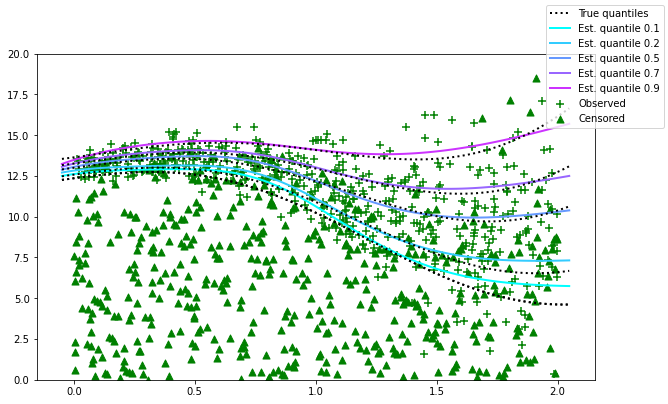

In [9]:
model.eval()
y_grid_preds = model(x_grid_torch).detach().cpu().numpy()

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(x_train[:][cen_indicator[0,:] == 0], y_train[:][cen_indicator[0,:] == 0],color='g',marker='+',s=70,label='Observed')
ax.scatter(x_train[:][cen_indicator[0,:] == 1], y_train[:][cen_indicator[0,:] == 1],color='g',marker='^',s=50,label='Censored')

ax.plot(x_grid, mydataset.get_quantile_truth(x_grid,q=taus[0]),label='True quantiles',color='k',linestyle=':', alpha=1.,lw=2.)
colors = plt.cm.cool(np.linspace(0,1,n_quantiles))
for i in range(n_quantiles-1):
  ax.plot(x_grid, y_grid_preds[:,i],label='Est. quantile '+str(round(taus[i],3)),color=colors[i], alpha=1.,lw=2.)
for i in range(n_quantiles-1):
  ax.plot(x_grid, mydataset.get_quantile_truth(x_grid,q=taus[i]),color='k',linestyle=':', alpha=1.,lw=2.)
ax.set_ylim([0,20])
fig.legend()
fig.show()